# Pandas data manipulation

In [1]:
# import numpy as np
import pandas as pd
import datetime


## Convert timerange to a timeseries

In [2]:

dti = pd.date_range("2018-01-05", periods=3, freq="W")

dti

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21'], dtype='datetime64[ns]', freq='W-SUN')

In [3]:

def distribute_per_week2(start, end, column_name, country):
    index = pd.date_range(start, end, freq="W").strftime('%Y-%U')
    df = index.to_frame(name='week')
    df['country'] = country
    df = df.set_index(['country','week'])
    df[column_name] = True
    return df    

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 3, 1)    
df = distribute_per_week2(start, end, 'concerts', 'Austria')

start1 = datetime.datetime(2020, 1, 1)
end1 = datetime.datetime(2020, 9, 1)    
df1 = distribute_per_week2(start1, end1, 'public', 'Austria')

res = df.join(df1, how='outer')
res = res.fillna(value=False)
res

concerts  public
country week                     
Austria 2019-01      True   False
        2019-02      True   False
        2019-03      True   False
        2019-04      True   False
        2019-05      True   False
...                   ...     ...
        2020-31     False    True
        2020-32     False    True
        2020-33     False    True
        2020-34     False    True
        2020-35     False    True

[87 rows x 2 columns]

In [4]:
index = pd.date_range(start, end, freq="W").strftime('%Y-%U')
index

Index(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2019-13', '2019-14', '2019-15', '2019-16', '2019-17', '2019-18',
       '2019-19', '2019-20', '2019-21', '2019-22', '2019-23', '2019-24',
       '2019-25', '2019-26', '2019-27', '2019-28', '2019-29', '2019-30',
       '2019-31', '2019-32', '2019-33', '2019-34', '2019-35', '2019-36',
       '2019-37', '2019-38', '2019-39', '2019-40', '2019-41', '2019-42',
       '2019-43', '2019-44', '2019-45', '2019-46', '2019-47', '2019-48',
       '2019-49', '2019-50', '2019-51', '2019-52', '2020-01', '2020-02',
       '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
       '2020-09'],
      dtype='object')

In [5]:
df = index.to_frame(name='weeks',index=False)

## Lets get our dataset from azure ml

In [6]:
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

dataset = Dataset.get_by_name(ws, name='covid-19-response-weekly')
dsf = dataset.to_pandas_dataframe()
dsf

capstone
ML
westeurope
f08c5f25-28be-4c21-993c-ad64d5c84d3a


,Country,Response_measure,date_start,date_end
0,Austria,AdaptationOfWorkplace,2020-03-10,NA
1,Austria,BanOnAllEvents,2020-11-03,NA
2,Austria,ClosDaycare,2020-03-16,2020-05-04
3,Austria,ClosDaycarePartial,2020-11-17,2020-12-07
4,Austria,ClosHigh,2020-03-16,2020-09-30
...,...,...,...,...
1430,United Kingdom,StayHomeRiskG,2020-03-16,2020-07-05
1431,United Kingdom,StayHomeRiskG,2020-11-05,2020-12-01
1432,United Kingdom,StayHomeRiskG,2021-01-05,NA
1433,United Kingdom,StayHomeRiskGPartial,2020-07-06,2020-08-01


## Now lets distribute the measures per week numbers

In [7]:
def data_framer(row):
    """Gets a dataframe row and converts it into a time series dataframe binned in weeks"""
    date_end = row['date_end'] if row['date_end'] != 'NA' else datetime.date.today()
    df = distribute_per_week2(row['date_start'], date_end, row['Response_measure'], row['Country'])
    return df


### Get each measure as a dataframe expanded with a flag per week it was on for each country

In [8]:
measures_per_week = dsf.apply(data_framer, axis=1)

### Lets see how the measure dataframes look like

In [9]:
measures_per_week[0]

AdaptationOfWorkplace
country week                          
Austria 2020-11                   True
        2020-12                   True
        2020-13                   True
        2020-14                   True
        2020-15                   True
        2020-16                   True
        2020-17                   True
        2020-18                   True
        2020-19                   True
        2020-20                   True
        2020-21                   True
        2020-22                   True
        2020-23                   True
        2020-24                   True
        2020-25                   True
        2020-26                   True
        2020-27                   True
        2020-28                   True
        2020-29                   True
        2020-30                   True
        2020-31                   True
        2020-32                   True
        2020-33                   True
        2020-34                   True
        2020-35                   True
        2020-36                   True
        2020-37                   True
        2020-38                   True
        2020-39                   True
        2020-40                   True
        2020-41                   True
        2020-42                   True
        2020-43                   True
        2020-44                   True
        2020-45                   True
        2020-46                   True
        2020-47                   True
        2020-48                   True
        2020-49                   True
        2020-50                   True
        2020-51                   True
        2020-52                   True
        2021-01                   True
        2021-02                   True
        2021-03                   True
        2021-04                   True
        2021-05                   True

### Concatenate the dataframes so that in fact we get an one hot encoded dataframe:

In [10]:
# concatenate measures per week and fill nan values with false
merged_measures_per_week = pd.concat(measures_per_week.array, axis=1).fillna(value=False)

### Concatenation resulted in duplicate columns present in the dataframe.
### To get rid of duplicat columns we need to run the following cell:

In [11]:
# merge duplicate columns
# transpose the initial dataframe '.T'
# group by row which have now duplicate index values (which were column names)
# apply the 'any' aggregation function 
# transpose back the result
merged_measures_per_week = merged_measures_per_week.T.groupby(level=0).any().T 
merged_measures_per_week

AdaptationOfWorkplace  AdaptationOfWorkplacePartial  \
country        week                                                           
Austria        2020-11                   True                         False   
               2020-12                   True                         False   
               2020-13                   True                         False   
               2020-14                   True                         False   
               2020-15                   True                         False   
...                                       ...                           ...   
United Kingdom 2021-01                  False                         False   
               2021-02                  False                         False   
               2021-03                  False                         False   
               2021-04                  False                         False   
               2021-05                  False                         False   

                        BanOnAllEvents  BanOnAllEventsPartial  ClosDaycare  \
country        week                                                          
Austria        2020-11           False                  False        False   
               2020-12           False                  False         True   
               2020-13           False                  False         True   
               2020-14           False                  False         True   
               2020-15           False                  False         True   
...                                ...                    ...          ...   
United Kingdom 2021-01           False                  False        False   
               2021-02            True                  False        False   
               2021-03            True                  False        False   
               2021-04            True                  False        False   
               2021-05            True                  False        False   

                        ClosDaycarePartial  ClosHigh  ClosHighPartial  \
country        week                                                     
Austria        2020-11               False     False            False   
               2020-12               False      True            False   
               2020-13               False      True            False   
               2020-14               False      True            False   
               2020-15               False      True            False   
...                                    ...       ...              ...   
United Kingdom 2021-01               False     False            False   
               2021-02               False     False             True   
               2021-03               False     False             True   
               2021-04               False     False             True   
               2021-05               False     False             True   

                        ClosPrim  ClosPrimPartial  ...  StayHomeGen  \
country        week                                ...                
Austria        2020-11     False            False  ...         True   
               2020-12      True            False  ...        False   
               2020-13      True            False  ...        False   
               2020-14      True            False  ...        False   
               2020-15      True            False  ...        False   
...                          ...              ...  ...          ...   
United Kingdom 2021-01     False            False  ...        False   
               2021-02     False             True  ...        False   
               2021-03     False             True  ...        False   
               2021-04     False             True  ...        False   
               2021-05     False             True  ...        False   

                        StayHomeGenPartial  StayHomeOrder  \
country        week                           

## Lets get the second dataset that contains the cases per week

In [12]:
dataset = Dataset.get_by_name(ws, name='covid-19-cases-deaths-weekly')
dsf = dataset.to_pandas_dataframe()
dsf

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source
0,Afghanistan,AFG,Asia,38928341,cases,0,2020-01,NaN,0,"Epidemic intelligence, national weekly data"
1,Afghanistan,AFG,Asia,38928341,cases,0,2020-02,0.000000,0,"Epidemic intelligence, national weekly data"
2,Afghanistan,AFG,Asia,38928341,cases,0,2020-03,0.000000,0,"Epidemic intelligence, national weekly data"
3,Afghanistan,AFG,Asia,38928341,cases,0,2020-04,0.000000,0,"Epidemic intelligence, national weekly data"
4,Afghanistan,AFG,Asia,38928341,cases,0,2020-05,0.000000,0,"Epidemic intelligence, national weekly data"
...,...,...,...,...,...,...,...,...,...,...
21087,Zimbabwe,ZWE,Africa,14862927,deaths,34,2020-52,3.162230,354,"Epidemic intelligence, national weekly data"
21088,Zimbabwe,ZWE,Africa,14862927,deaths,26,2020-53,4.036890,380,"Epidemic intelligence, national weekly data"
21089,Zimbabwe,ZWE,Africa,14862927,deaths,127,2021-01,10.294069,507,"Epidemic intelligence, national weekly data"
21090,Zimbabwe,ZWE,Africa,14862927,deaths,206,2021-02,22.404739,713,"Epidemic intelligence, national weekly data"


In [13]:
dsf2 = dsf \
.drop(columns=['country_code','source']) \
.rename(columns={'year_week':'week'}) \
.set_index(['indicator','continent','country', 'week']) \
.loc[('deaths','Europe')]

dsf2

population  weekly_count  rate_14_day  \
country        week                                             
Albania        2020-10     2862427             0          NaN   
               2020-11     2862427             1     0.349354   
               2020-12     2862427             1     0.698708   
               2020-13     2862427             8     3.144185   
               2020-14     2862427            11     6.637724   
...                            ...           ...          ...   
United Kingdom 2020-52    66647112          3708   104.115539   
               2020-53    66647112          3915   114.378550   
               2021-01    66647112          6407   154.875428   
               2021-02    66647112          7830   213.617658   
               2021-03    66647112          8678   247.692653   

                        cumulative_count  
country        week                       
Albania        2020-10                 0  
               2020-11                 1  
               2020-12                 2  
               2020-13                10  
               2020-14                21  
...                                  ...  
United Kingdom 2020-52             71109  
               2020-53             75024  
               2021-01             81431  
               2021-02             89261  
               2021-03             97939  

[2947 rows x 4 columns]

In [15]:
res2 = dsf2 \
.join(merged_measures_per_week) \
.apply(lambda x: x.abs().fillna(0) if x.dtype.kind in 'iufc' else x.fillna(False)) \
.sort_index()
res2


population  weekly_count  \
country                          week                                
Albania                          2020-10     2862427             0   
                                 2020-11     2862427             1   
                                 2020-12     2862427             1   
                                 2020-13     2862427             8   
                                 2020-14     2862427            11   
...                                              ...           ...   
the Holy See/ Vatican City State 2020-52         809             0   
                                 2020-53         809             0   
                                 2021-01         809             0   
                                 2021-02         809             0   
                                 2021-03         809             0   

                                          rate_14_day  cumulative_count  \
country                          week                                     
Albania                          2020-10     0.000000                 0   
                                 2020-11     0.349354                 1   
                                 2020-12     0.698708                 2   
                                 2020-13     3.144185                10   
                                 2020-14     6.637724                21   
...                                               ...               ...   
the Holy See/ Vatican City State 2020-52     0.000000                 0   
                                 2020-53     0.000000                 0   
                                 2021-01     0.000000                 0   
                                 2021-02     0.000000                 0   
                                 2021-03     0.000000                 0   

                                          AdaptationOfWorkplace  \
country                          week                             
Albania                          2020-10                  False   
                                 2020-11                  False   
                                 2020-12                  False   
                                 2020-13                  False   
                                 2020-14                  False   
...                                                         ...   
the Holy See/ Vatican City State 2020-52                  False   
                                 2020-53                  False   
                                 2021-01                  False   
                                 2021-02                  False   
                                 2021-03                  False   

                                          AdaptationOfWorkplacePartial  \
country                          week                                    
Albania                          2020-10                         False   
                                 2020-11                         False   
                                 2020-12                         False   
                                 2020-13                         False   
                                 2020-14                         False   
...                                                                ...   
the Holy See/ Vatican City State 2020-52                         False   
                                 2020-53                         False   
                                 2021-01                         False   
                                 2021-02                         False   
                                 2021-03                         False   

                                          BanOnAllEvents  \
country                          week                      
Albania                          2020-10           False   
                                 2020-11           False   
                                 2020-12           False   
                    

In [21]:
res2.loc['Austria']

,population,weekly_count,rate_14_day,cumulative_count,AdaptationOfWorkplace,AdaptationOfWorkplacePartial,BanOnAllEvents,BanOnAllEventsPartial,ClosDaycare,ClosDaycarePartial,...,StayHomeGen,StayHomeGenPartial,StayHomeOrder,StayHomeOrderPartial,StayHomeRiskG,StayHomeRiskGPartial,Teleworking,TeleworkingPartial,WorkplaceClosures,WorkplaceClosuresPartial
week,,,,,,,,,,,,,,,,,,,,,
2020-01,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-02,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-04,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-05,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-06,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-07,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-08,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-09,8858775,0,0.000000,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


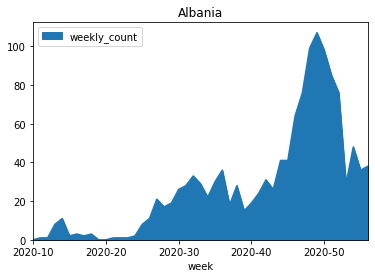

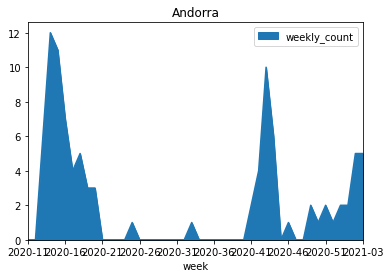

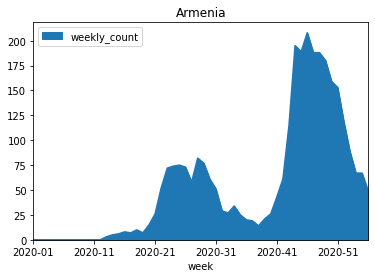

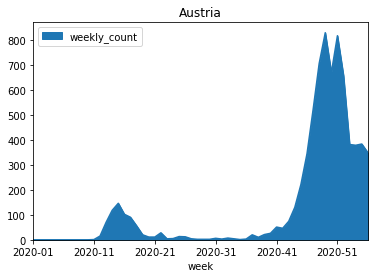

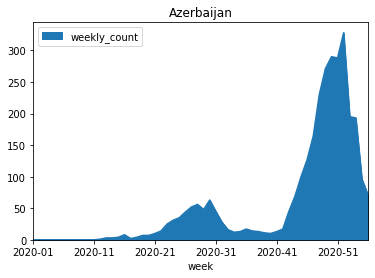

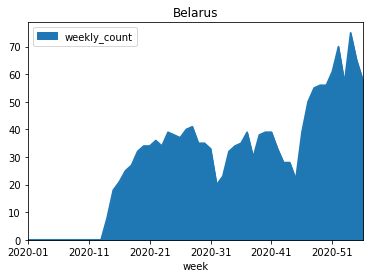

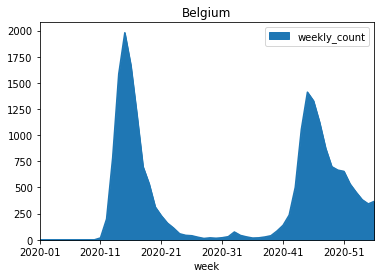

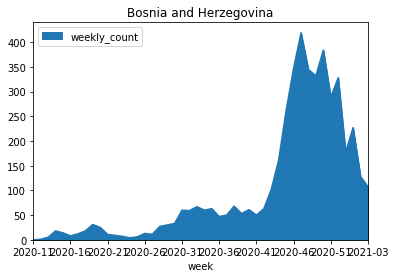

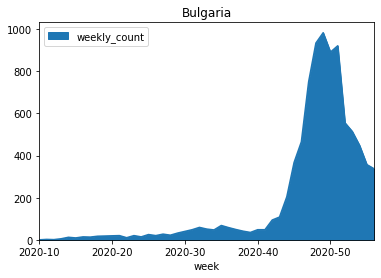

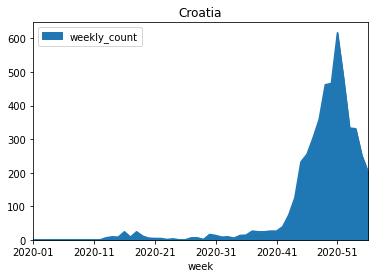

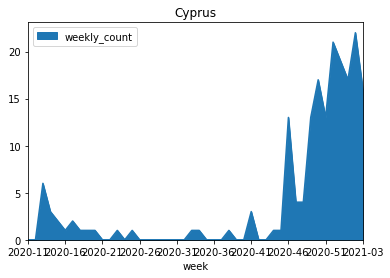

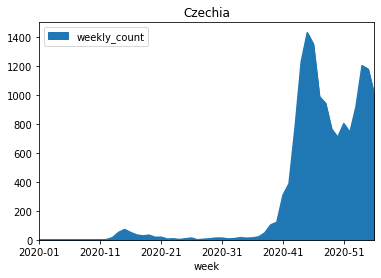

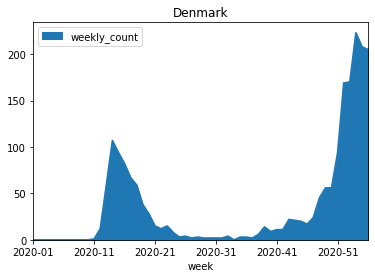

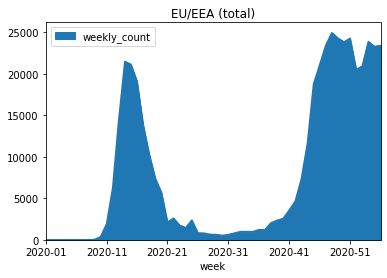

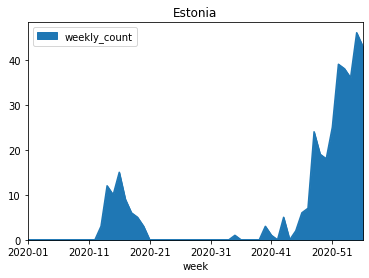

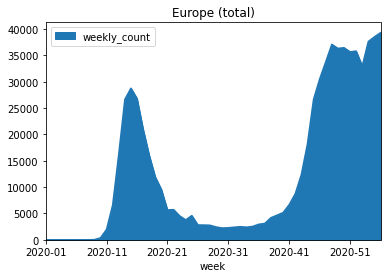

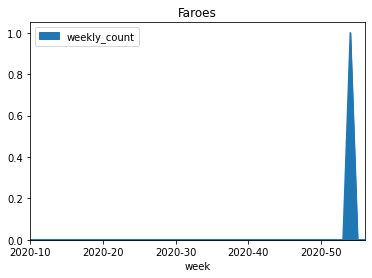

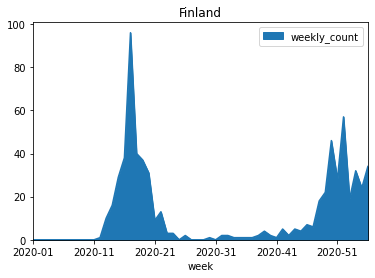

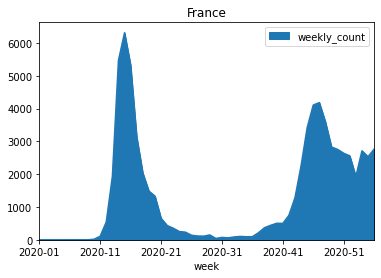

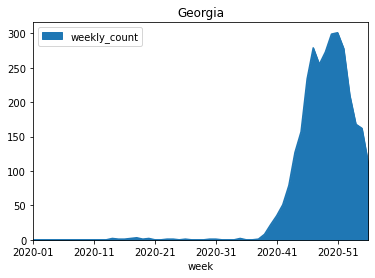

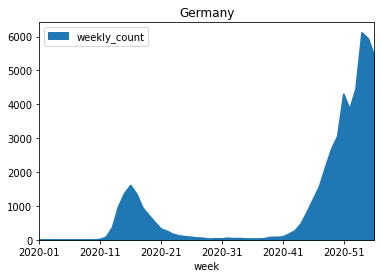

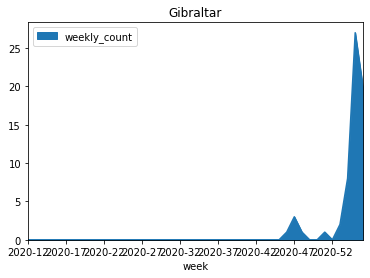

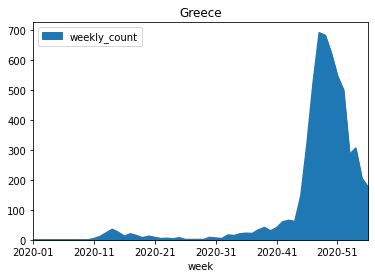

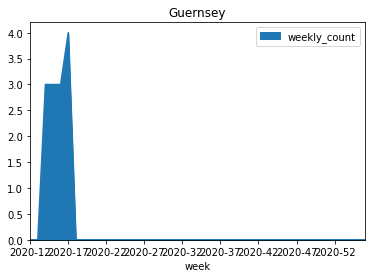

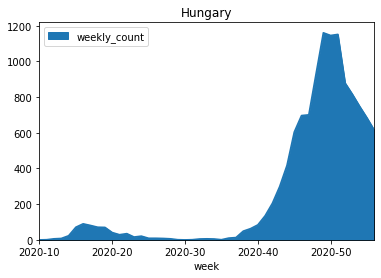

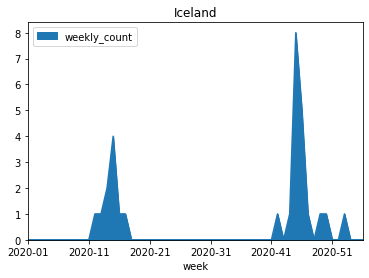

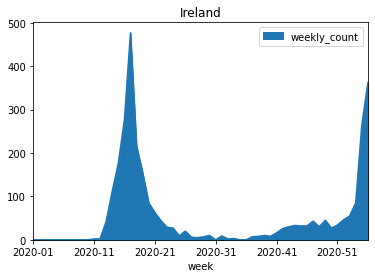

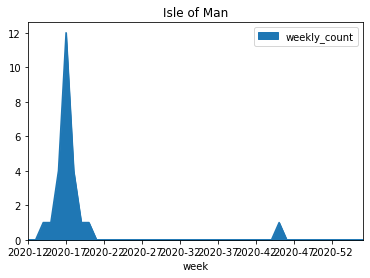

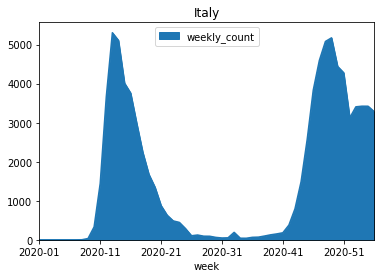

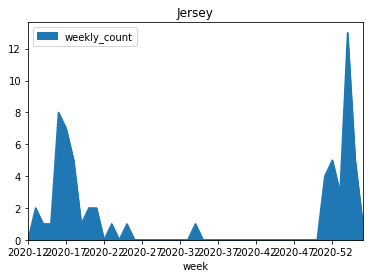

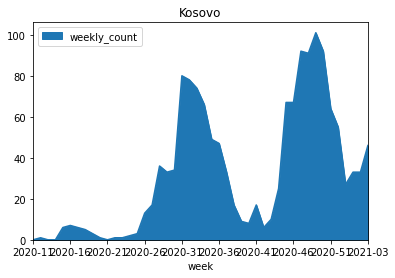

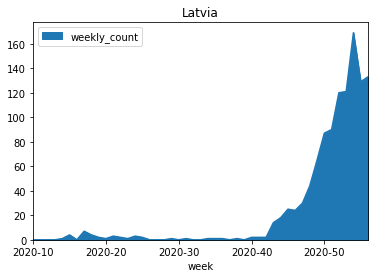

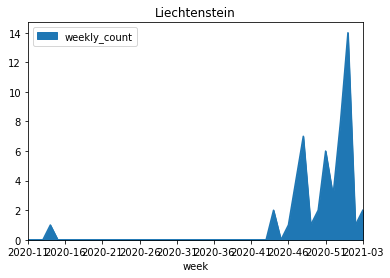

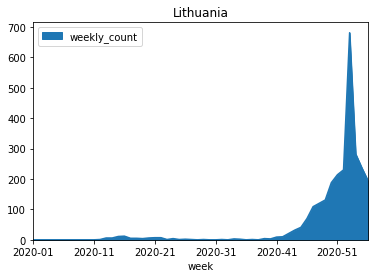

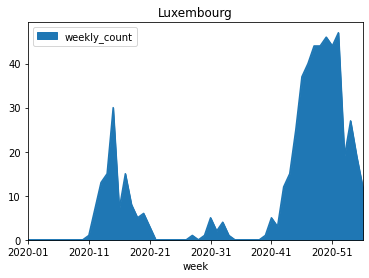

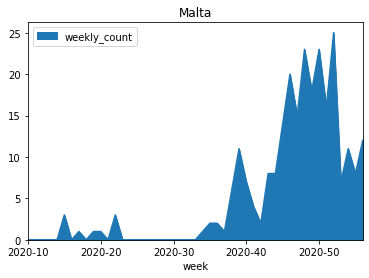

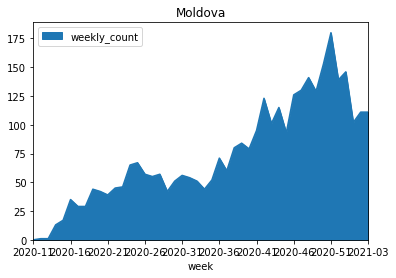

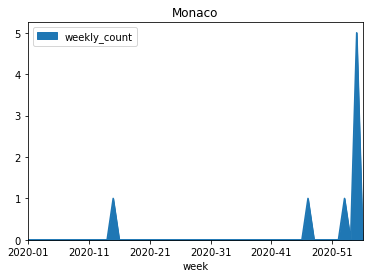

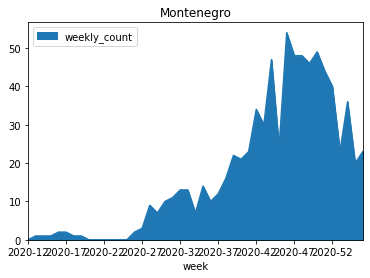

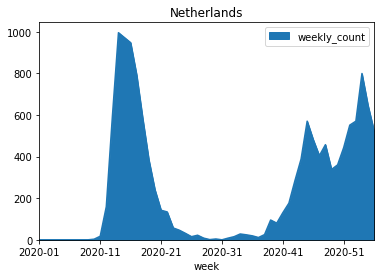

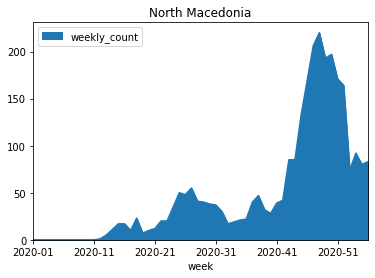

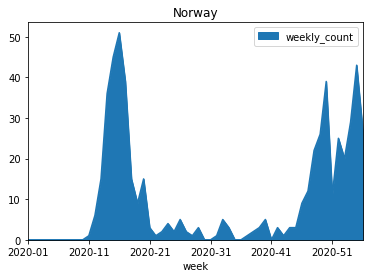

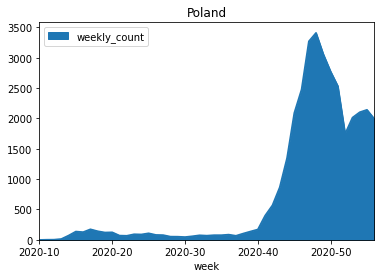

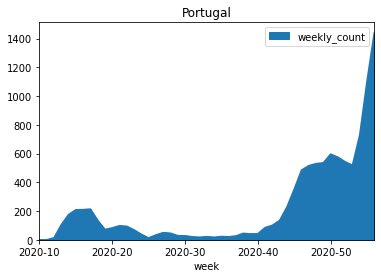

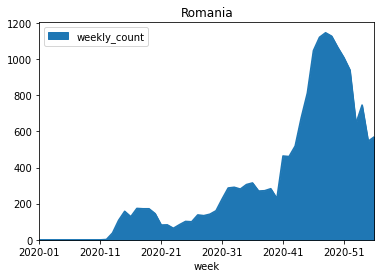

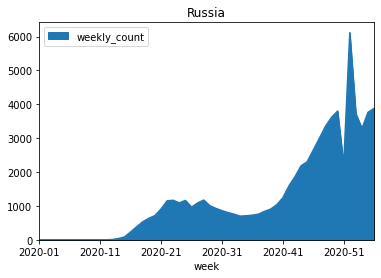

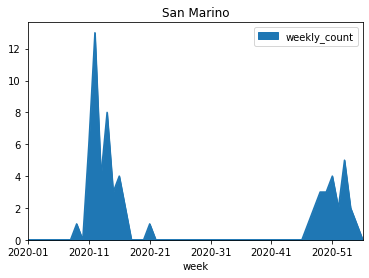

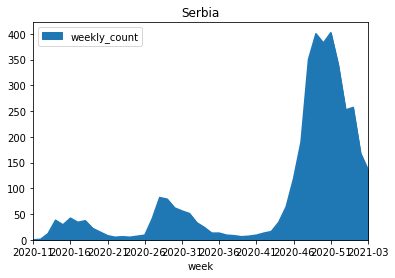

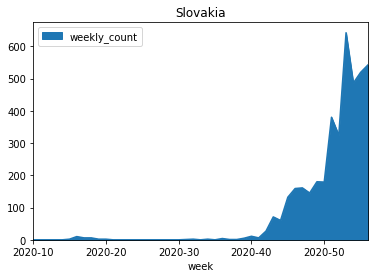

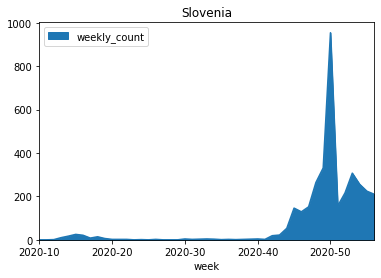

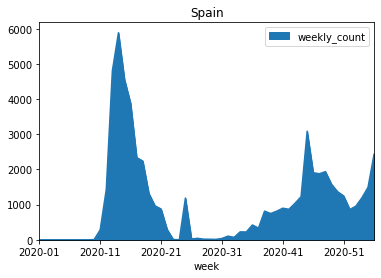

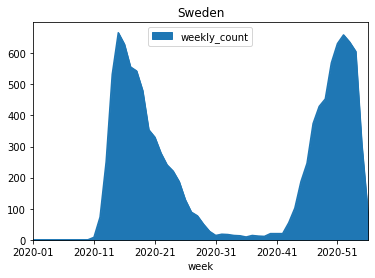

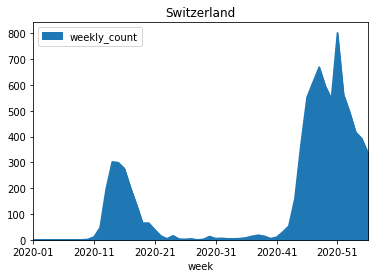

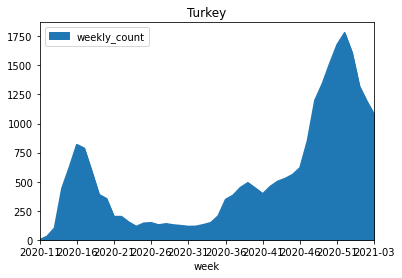

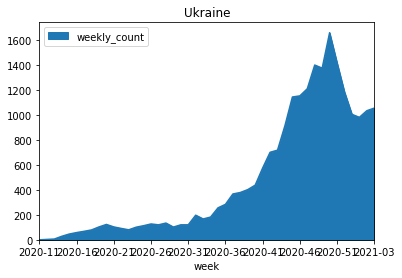

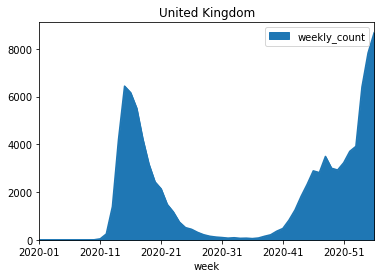

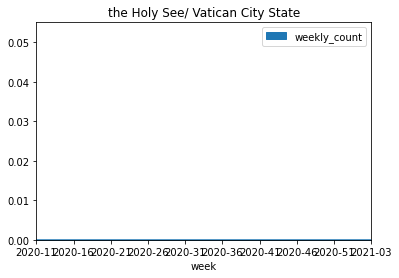

In [20]:
for i in res2.index.get_level_values('country').unique():
    res2.loc[i].plot(title=i, y=['weekly_count','AdaptationOfWorkplace'],kind='area')


In [ ]:
# dataset_test = Dataset.Tabular.from_delimited_files('test.csv')
# df_test = dataset_test.to_pandas_dataframe()
df_test = pd.read_csv('../test.csv', index_col=0)
df_test = df_test[pd.notnull(df_test['rate_14_day'])]

y_test = df_test['rate_14_day']
X_test = df_test.drop(['rate_14_day'], axis=1)
# y_test
df_test